In [2]:
%load_ext autoreload
%autoreload 2

import os
import time
import glob
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import csv
import cv2
import torchvision.transforms as transforms
import joblib

#libraries for yolo
from pytorchyolo.models import load_model
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS
from pytorchyolo.utils.utils import non_max_suppression
from pytorchyolo.utils.loss import compute_loss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
from scripts.utils import detach_cpu, tensor_to_np_img, save_tensor_img, clone_detach, open_img_as_tensor, display_img

## Face Detector Models

In [4]:
from scripts.face_detectors import MediaPipe, YuNet, YoloFace

In [5]:
mp = MediaPipe()
yn = YuNet()
yf = YoloFace()

## Our Model

In [54]:
from scripts.custom_mlp import *
our_model = joblib.load("model_dumps/best_one.pkl")

## YOLOFace with FGSM

In [12]:
# Patterned after FGSM tutorial (https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)
# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
main_yf = YoloFace()
device, model = main_yf.device, main_yf.yf_face_detector


# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

## Image Feature Extraction

In [13]:
from scripts import image_attributes
from scripts.image_attributes import extract_image_attributes

## Load Masks

## FGSM

In [30]:
import scripts.fgsm as fgsm

In [48]:
def get_features(path):
    torch.autograd.set_detect_anomaly(True)
    
    df = pd.DataFrame() # dataframe storing the dataset
    row = {} #the information/columns for a single row in the dataset is stored here
    grads = []
    bboxes = []
    
    file_basename = os.path.basename(path)
    print(file_basename, end=" ")
    print("<- working on")

    row['path'] = path

    model.eval()
    model.gradient_mode = False

    for yolo_layer in model.yolo_layers:
        yolo_layer.gradient_mode = False

    # Read and transform the image from the path
    data = cv2.imread(path)
    row['source_w'], row['source_h'], _ = data.shape
    data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
    data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0)

    with torch.no_grad():
        # Forward pass the data through the model and call non max suppression
        nms, nms_output = non_max_suppression(model(data), 0.5, 0.5) #conf_thres and iou_thres = 0.5

    face_list = []
    if type(nms_output[0]) is not int:
        face_list = nms_output[0]

    data = data.to(device)

    # Set requires_grad attribute of tensor. Important for attack
    data.requires_grad = True

    model.gradient_mode = True
    for yolo_layer in model.yolo_layers:
        yolo_layer.gradient_mode = True

    output = model(data)

    # loop through each of the faces in the image
    for face_index, face_row in enumerate(face_list): #nms_output[0] because the model is designed to take in several images at a time from the dataloader but we are only loading the image one at a time

        row['face_index'] = face_index
        print("Face", face_index)

        row['obj_score'] = face_row[4].item()
        row['class_score'] = face_row[5].item()
        x, y, w, h = face_row[0], face_row[1], face_row[2], face_row[3]

        normal_x, normal_y, normal_w, normal_h = x / 415, y / 415, w / 415, h / 415

        if fgsm_loss_target == "bbox":
            target = torch.tensor([[face_row[4].item(), face_row[5].item(), 0, 0, 0, 0]])
        elif fgsm_loss_target == "conf":
            target = torch.tensor([[0.0, 0, normal_x, normal_y, normal_w, normal_h]])

        target = target.to(device)
        loss, loss_components = compute_loss(output, target, model)

        # cropped image with bounding box
        # getting (x1, y1) upper left, (x2, y2) lower right
        x1 = max(int(np.floor((x - w / 2).detach().cpu().numpy())), 0)
        y1 = max(int(np.floor((y - h / 2).detach().cpu().numpy())), 0)
        x2 = min(int(np.ceil((x + w / 2).detach().cpu().numpy())), 415)
        y2 = min(int(np.ceil((y + h / 2).detach().cpu().numpy())), 415)

        row['x1'], row['y1'], row['x2'], row['y2'] = x1, y1, x2, y2
        row['x'], row['y'], row['w'], row['h'] = x, y, w, h
        
        cropped_image = detach_cpu(data)[:, :, y1:y2, x1:x2] #get the first dimension, the channels, and crop it
        cropped_image = tensor_to_np_img(cropped_image) #reshape the image to (w/h, h/w, channel)

        # Zero all existing gradients
        model.zero_grad()
        data.grad = None

        # Calculate gradients of model in backward pass
        loss.backward(retain_graph=True) #TODO: Amos - check if this is correct
        
        # Collect datagrad
        data_grad = data.grad.data
        grads.append(clone_detach(data_grad))
        
        bbox = (x1, y1, x2, y2)
        bboxes.append(bbox)
        
        row = extract_image_attributes(row, path, face_index, cropped_image, "bbox")
        
        df = pd.concat([df, pd.DataFrame([row])], axis=0, ignore_index=True)
    
    return df, grads, bboxes

In [49]:
# Settings
image_attributes.save_color_images = False
image_attributes.save_lbp_images = False
image_attributes.save_gradient_images = False
fgsm_loss_target = "conf" # or "bbox"

In [50]:
input_image = r"./images/1--Handshaking/1_Handshaking_Handshaking_1_51.jpg"

1_Handshaking_Handshaking_1_51.jpg <- working on
Face 0
Face 1


In [67]:
t1 = time.time()
data = open_img_as_tensor(input_image)
feats, grads, bboxes = get_features(input_image)
feats = preprocess(feats.loc[:, our_model.feature_names_in_])
preds = our_model.predict(feats)
for e, data_grad, bbox in zip(preds, grads, bboxes):
    bbox_mask = np.zeros(data.shape)
    bbox_mask[..., bbox[1]:bbox[3], bbox[0]:bbox[2]] = 1
    data = fgsm.fgsm_attack(data, e, data_grad, bbox_mask)
t2 = time.time()
print("run time:", t2 - t1)
display_img(data)

1_Handshaking_Handshaking_1_51.jpg <- working on
Face 0
Face 1
run time: 32.9880166053772


NameError: name 'display_img' is not defined

In [70]:
t1 = time.time()
data = open_img_as_tensor(input_image)
for data_grad, bbox in zip(grads, bboxes):
    bbox_mask = np.zeros(data.shape)
    bbox_mask[..., bbox[1]:bbox[3], bbox[0]:bbox[2]] = 1
    e = fgsm.binary_search(clone_detach(data), clone_detach(data_grad), yf, bbox_mask, bbox)
    data = fgsm.fgsm_attack(data, e, data_grad, bbox_mask)
t2 = time.time()
print("run time:", t2 - t1)
display_img(data)

run time: 104.74794030189514


NameError: name 'perturbed_img' is not defined

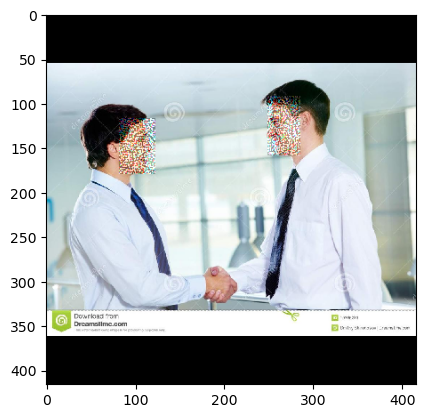

In [71]:
display_img(data)

##### ___